installing dependencies

In [ ]:
!pip install pytorch-lightning
!pip install keyboard
!pip install colorama

From Common.py 

In [1]:
import torch as T
import torch.jit
import torch.nn as nn
import pytorch_lightning as pl

DEVICE = 'cuda:0' if T.cuda.is_available() else 'cpu'


class Conv(pl.LightningModule):
    def __init__(self, c1: int, c2: int, act: bool = True, batch: bool = False, **kwargs):
        super(Conv, self).__init__()
        self.c1 = c1
        self.c2 = c2
        self.act = act
        self.batch = batch
        self.to(DEVICE)
        self.conv = nn.Conv2d(c1, c2, **kwargs).to(DEVICE)
        self.r = nn.LeakyReLU(0.2).to(DEVICE)
        self.n = nn.BatchNorm2d(c2).to(DEVICE)

    def forward(self, x) -> T.Tensor:

        x = self.conv(x)
        if self.batch:
            x = self.n(x)
        if self.act:
            x = self.r(x)

        return x


class Neck(pl.LightningModule):
    def __init__(self, c1, c2, e=0.5, shortcut=False):
        super(Neck, self).__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, kernel_size=1, stride=1)
        self.cv2 = Conv(c_, c2, kernel_size=3, stride=1, padding=1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        ck = self.cv2(self.cv1(x))

        k = x + ck if self.add else ck

        return k


class C3(pl.LightningModule):
    def __init__(self, c1, c2, e=0.5, n=1, shortcut=True):
        super(C3, self).__init__()
        c_ = int(c2 * e)
        self.cv1 = Conv(c1, c_, kernel_size=3, stride=1, padding=1)
        self.cv2 = Conv(c1, c_, kernel_size=3, stride=1, padding=1)
        self.cv3 = Conv(c_ * 2, c2, kernel_size=3, padding=1)
        self.m = nn.Sequential(*(Neck(c_, c_, shortcut=shortcut, e=0.5) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv2(x)), self.cv1(x)), dim=1))


class C4P(C3):
    def __init__(self, c, e=0.5, n=1, ct=2):
        super(C4P, self).__init__(c1=c, c2=c, e=e, n=n)
        self.ct = ct

    def forward(self, x):
        for _ in range(self.ct):
            x = self.cv3(torch.cat((self.m(self.cv2(x)), self.cv1(x)), dim=1)) + x
        return x


class RepConv(pl.LightningModule):
    def __init__(self, c, e=0.5, n=3):
        super(RepConv, self).__init__()
        c_ = int(c * e)
        self.layer = nn.ModuleList()
        # self.layer.append(
        #     *(Conv(c1=c if i == 0 else c_, c2=c_ if i == 0 else c, kernel_size=3, padding=1, stride=1, batch=False)
        #       for i in range(n)))
        for i in range(n):
            self.layer.append(
                Conv(c1=c if i == 0 else c_, c2=c_ if i == 0 else c, kernel_size=3, padding=1, stride=1, batch=False))

    def forward(self, x):
        x_ = x
        for layer in self.layer:
            x = layer.forward(x)
        return x_ + x


class ConvSc(RepConv):
    def __init__(self, c, n=4):
        super(ConvSc, self).__init__(c=c, e=1, n=n)

    def forward(self, x):
        x_ = x.detach().clone()
        for layer in self.layer:
            x = layer(x) + x
        return x + x_


class ResidualBlock(pl.LightningModule):
    def __init__(self, c1, n: int = 4, use_residual: bool = True):
        super(ResidualBlock, self).__init__()
        self.use_residual = use_residual
        self.n = n
        self.to(DEVICE)
        self.layer = nn.ModuleList()

        for _ in range(n):
            self.layer.append(
                nn.Sequential(
                    Conv(c1, c1 * 2, act=True, batch=True, stride=1, padding=0, kernel_size=1),
                    Conv(c1 * 2, c1, act=True, batch=True, stride=1, padding=1, kernel_size=3)
                )
            )

    def forward(self, x) -> T.Tensor:
        c = x
        for layer in self.layer:
            x = layer(x)
        return x + c if self.use_residual else x


class Detect(pl.LightningModule):
    def __init__(self, c1, nc):
        super(Detect, self).__init__()
        self.nc = nc
        self.to(DEVICE)
        self.layer = nn.Sequential(
            Conv(c1=c1, c2=c1 * 2, act=True, batch=False, kernel_size=1),
            Conv(c1=c1 * 2, c2=(5 + self.nc) * 3, kernel_size=1, batch=False, padding=0, stride=1, act=True)
        )

    def forward(self, x) -> T.Tensor:
        return self.layer(x).reshape(x.shape[0], 3, self.nc + 5, x.shape[2], x.shape[3]).permute(0, 1, 3, 4, 2)


class CV1(pl.LightningModule):
    def __init__(self, c1, c2, e=0.5, n=1, shortcut=False, dim=-3):
        super(CV1, self).__init__()
        c_ = int(c2 * e)
        if shortcut:
            c2 = c1
        self.c = Conv(c1, c_, kernel_size=3, padding=1, stride=1)
        self.v = Conv(c1, c_, kernel_size=3, padding=1, stride=1)
        self.m = nn.Sequential(
            *(Conv(c_ * 2 if i == 0 else c2, c2, kernel_size=3, stride=1, padding=1) for i in range(n)))
        self.sh = c1 == c2
        self.dim = dim

    def forward(self, x):
        c = torch.cat((self.c(x), self.v(x)), dim=self.dim)
        return self.m(c) if not self.sh else self.m(
            torch.cat((self.c(x), self.v(x)), dim=self.dim)) + x


class UC1(pl.LightningModule):
    def __init__(self, c1, c2, e=0.5, dim=-3):
        super(UC1, self).__init__()
        c_ = int(c2 * e)
        self.c = Conv(c1=c1, c2=c_, kernel_size=1, stride=1)
        self.v = Conv(c1=c1, c2=c_, kernel_size=1, stride=1)
        self.m = Conv(c1=c_, c2=c2, kernel_size=1, stride=1)
        self.dim = dim

    def forward(self, x):
        return self.m(torch.cat((self.c(x), self.v(x)), dim=self.dim))


class MP(pl.LightningModule):
    def __init__(self):
        super(MP, self).__init__()
        self.ls = None

    def forward(self, x, ls):
        ls.append(x)
        return ls


from utils folder

In [2]:
import yaml
from colorama import Fore
import os
import sys
import numpy as np
import torch
import torch as T
import yaml
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
import cv2 as cv
import keyboard
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patche
import random
from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm


def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """

    boxes1 = torch.tensor(boxes1)

    boxes1 = boxes1.reshape(1, -1)
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * \
                   torch.min(
                       boxes1[..., 1], boxes2[..., 1]
                   )
    union = (
            boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0
    This function calculates intersection over union (iou) given pred boxes
    and target boxes.
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Video explanation of this function:
    https://youtu.be/YDkjWEN8jNA
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
               or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
               < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
        pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Video explanation of this function:
    https://youtu.be/FppOzcDvaDI
    This function calculates mean average precision (mAP)
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    average_precisions = []

    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
        
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
               
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
             
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
      
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



class LoadObjectDetectorModule(pl.LightningModule):
    def __init__(self, path):
        super(LoadObjectDetectorModule, self).__init__()
        self.path = path
        self.model = self.load_mo()

    def load_mo(self):
        return torch.load(self.path)

    def show(self):
        print('{:>35}{:>20}'.format('Ran Epochs :', self.model['epoch']))
        print('{:>35}{:>20}'.format('Model Load Status :', 'True' if self.model['model'] else 'False'))
        print('{:>35}{:>20}'.format('Optim Load Status :', 'True' if self.model['optim'] else 'False'))

    def load(self):
        return self.model['model'], self.model['optim'], self.model['epoch']



def show(array: (np.ndarray, list, tuple)):
    while True:
        if isinstance(array, list):
            array = np.array(array)
        if array.shape[0] == 3:
            array = array.reshape((array.shape[1], array.shape[2], array.shape[0]))
        array = array.astype(np.uint8)
        cv.imshow('show function', array)
        cv.waitKey(1)
        if keyboard.is_pressed('q'):
            break

cfg = [
    {'name': 'Conv',
     'attributes': [3, 32, 3, 1, True, True]},
    {'name': 'Conv',
     'attributes': [32, 64, 3, 2, True, True]},
    {'name': 'ResidualBlock',
     'attributes': [64, 4, True]},
    {'name': 'C3',
     'attributes': [64, 128, True, 2, 0.8]},
    {'name': 'Conv',
     'attributes': [128, 256, 3, 2, True, True]},
    {'name': 'ResidualBlock',
     'attributes': [256, 2, True]},
    {'name': 'RepConv',
     'attributes': [256, 1, 2]},
    {'name': 'Conv',
     'attributes': [256, 384, 3, 2, True, True]},
    {'name': 'Detect',
     'attributes': [384, 4]},  # Detect
    {'name': 'RepConv',
     'attributes': [384, 1, 2]},
    {'name': 'Conv',
     'attributes': [384, 512, 3, 2, True, True]},
    {'name': 'Detect',
     'attributes': [512, 4]},  # Detect
    {'name': 'RepConv',
     'attributes': [512, 1, 2]},
    {'name': 'Conv',
     'attributes': [512, 768, 3, 2, True, True]},
    {'name': 'Detect',
     'attributes': [768, 4]},  # Detect
]



DEVICE = 'cuda:0' if T.cuda.is_available() else 'cpu'


class DataReader(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, item, train: bool = True):
        x, y = [self.x[item], self.y[item]]
        return x, y


class DataLoaderLightning(LightningDataModule):
    def __init__(self, path, debug: bool = False, nc: int = 4, val_pers=0.3, batch_size: int = 6, prc: float = 0.3,
                 img_shape: int = 416, val_perc: float = 0.9):
        super(DataLoaderLightning, self).__init__()
        with open(path, 'r') as r:
            iw = yaml.full_load(r)
        self.debug = debug
        self.nc = nc
        self.val_pers = val_pers
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.val_perc = val_perc
        self.debug = debug
        self.prc = prc
        self.path_train = os.path.join(os.getcwd(), iw['train'])
        self.path_valid = os.path.join(os.getcwd(), iw['valid'])
        # self.path_train = iw['train']
        # self.path_valid = iw['valid']
        # self.path_train = os.path.join('E:/Programming/Python/Ai-Projects/ObjectDetectorModule', iw['train'])
        # self.path_valid = os.path.join('E:/Programming/Python/Ai-Projects/ObjectDetectorModule', iw['valid'])
        self.nc = nc
        self.ti = [t for t in os.listdir(self.path_train) if os.path.exists(os.path.join(self.path_train, t)) and
                   t.endswith('.jpg')]
        self.vi = [v for v in os.listdir(self.path_valid) if os.path.exists(os.path.join(self.path_valid, v)) and
                   v.endswith('.jpg')]
        self.s = [13, 26, 52]

        np.seterr(all='ignore')
        self.total = len(self.ti) if not self.debug else int(len(self.ti) / self.prc)
        self.x_train, self.y_train = self.__start__(current=self.ti)
        self.x_val, self.y_val = self.__start__(current=self.vi, is_val=True)

    def __start__(self, current, is_val: bool = False):
        xsl, ysl = [], []
        path = self.path_valid if is_val else self.path_train
        tm = len(current) if not self.debug else int(len(current) * (self.prc if not is_val else self.val_perc))
        print(f"Loading {tm} Samples")
        for item in range(tm):

            with open(f'{path}/{current[item][:-4]}.txt', 'r') as r:
                sr = r.readline()

            bboxes = np.roll(
                np.loadtxt(f'{path}/{current[item][:-4]}.txt', delimiter=" ", ndmin=2, ), 4,
                axis=1).tolist() if len(sr) != 0 else []

            targets = [torch.zeros(3, S, S, 5 + self.nc) for S in self.s]
            for box in bboxes:
                x1, y1, w, h, class_label = box
                dpa = torch.zeros(self.nc)

                dpa[int(class_label)] = 1
                class_label = dpa
                has_anchor = [False] * 3
                for anchor_idx in range(3):
                    scale_idx = torch.div((1e-16 + anchor_idx), other=3)
                    scale_idx = int(scale_idx)
                    anchor_on_scale = anchor_idx % 3
                    S = self.s[scale_idx]
                    i, j = int(S * y1), int(S * x1)

                    anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                    if not anchor_taken and not has_anchor[scale_idx]:
                        targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                        x_cell, y_cell = S * x1 - j, S * y1 - i

                        box_coordinates = torch.tensor(
                            [x1 * S, y1 * S, h * S, h * S]
                        )
                        targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                        targets[scale_idx][anchor_on_scale, i, j, 5:] = class_label

                        has_anchor[scale_idx] = True

            img = Image.open(f'{path}/{current[item][:-4]}.jpg')
            to_tensor = lambda ten: torch.from_numpy(ten)
            tt = lambda xf: xf.type(T.float64)
            tn = lambda xr: xr / 255
            ts = lambda xs: xs.reshape((self.img_shape, self.img_shape, 3))
            data = img.getdata()
            image_pixel = list(list(pixel) for pixel in data)
            image_rgb = np.array(image_pixel).reshape((self.img_shape, self.img_shape, 3))
            image_bgr = image_rgb[:, :, ::-1]
            x = to_tensor(image_rgb)
            x = ts(tn(tt(x))).permute(2, 1, 0).reshape(3, self.img_shape, self.img_shape)
            if DEVICE == 'cuda:0':
                x = x.type(T.cuda.FloatTensor)
            else:
                x = x.type(T.FloatTensor)
            xsl.append(x)
            ysl.append(tuple(targets))

            sys.stdout.write('\r Moving Data To Ram Or Gpu %{} remaining '.format(
                f"{((item / tm) * 100):.4f}"))
        sys.stdout.write('\n')
        return xsl, ysl

    def train_dataloader(self):
        data_train = DataReader(self.x_train, self.y_train)
        return DataLoader(data_train, batch_size=self.batch_size, num_workers=6)

    def val_dataloader(self):
        data_val = DataReader(self.x_val, self.y_val)
        return DataLoader(data_val, batch_size=self.batch_size, num_workers=6)


from loss.py


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

DEVICE = 'cuda:0' if torch.cuda.is_available() else "cpu"


def iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3],
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3],

    intersect_x1 = torch.max(b1_x1, b2_x1)
    intersect_y1 = torch.max(b1_y1, b2_y1)
    intersect_x2 = torch.min(b1_x2, b2_x2)
    intersect_y2 = torch.min(b1_y2, b2_y2)

    intersect_area = (intersect_x2 - intersect_x1 + 1) * (intersect_y2 - intersect_y1 + 1)

    # union area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    return intersect_area / (b1_area + b2_area - intersect_area + 1e-16)


class Loss(pl.LightningModule):
    def __init__(self):
        super(Loss, self).__init__()
        self.ac = 1e-16
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ca = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.to(DEVICE)
        self.anc = [
            [[10 / 7, 13 / 7], [16 / 7, 30 / 7], [33 / 7, 23 / 7]],
            [[30 / 26, 61 / 26, ], [62 / 26, 45 / 26, ], [59 / 26, 119 / 26]],
            [[116 / 52, 90 / 52, ], [156 / 52, 198 / 52, ], [373 / 52, 326 / 52],
             ]]
        self.anc = torch.tensor(self.anc[0] + self.anc[2] + self.anc[2])

    def forward(self, x, y, index):
        obj = y[..., 0] == 1
        no_obj = y[..., 0] == 0
        # print(y[obj])
        nol = self.bce(
            (x[..., 0:1][no_obj]).to(DEVICE), (y[..., 0:1][no_obj].to(DEVICE))
        )
        # print(self.anc)
        # print(self.anc[l * 3:(l * 3) + 3])
        anc = self.anc[index:index + 3].reshape(1, 3, 1, 1, 2)
        box_pred = torch.cat(
            [self.sigmoid(x[..., 1:3]).to(DEVICE), torch.exp(x[..., 3:5]).to(DEVICE) * anc.to(DEVICE)],
            dim=-1)
        ious = intersection_over_union(box_pred[obj].to(DEVICE), y[..., 1:5][obj].to(DEVICE)).detach()

        ol = self.mse(
            self.sigmoid(x[..., 0:1][obj]).to(DEVICE), (ious.to(DEVICE) * y[..., 0:1][obj].to(DEVICE))
        )

        x[..., 1:3] = self.sigmoid(x[..., 1:3])
        y[..., 3:5] = torch.log(
            (1e-16 + y[..., 3:5])
        )

        box_loss = self.mse(x[..., 1:5][obj], y[..., 1:5][obj].to(DEVICE))

        class_loss = self.bce(
            (F.softmax(x[..., 5:][obj], dim=-1).to(DEVICE)), (y[..., 5:][obj].float().to(DEVICE))
        )

        loss = nol * 1 + box_loss * 1 + ol * 1 + class_loss * 1

        return loss


Train Class


In [ ]:
import sys

import numpy as np
import torch
import torch.optim as optim
from colorama import Fore

import pytorch_lightning as pl
from pytorch_lightning.callbacks import BackboneFinetuning, Checkpoint, LearningRateMonitor, ModelCheckpoint, Timer, \
    EarlyStopping
import warnings


class TrainDi:
    def __init__(self):
        self.DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    def run(self):
        return NotImplementedError

    def load(self, path):
        return NotImplementedError

    def jit_save(self):
        return NotImplementedError


class OldMethodTrain(TrainDi):
    def __init__(self, nc: int = 4, cfg_path: str = 'cfg.yaml'):
        super(OldMethodTrain, self).__init__()
        self.nc = nc
        self.cfg_path = cfg_path
        self.net = ObjectDetectorModule(nc=nc, cfg_path=cfg_path).to(self.DEVICE)
        self.dr = DataReader(yaml_path='data/path.yaml', nc=nc, debug=True)
        self.loss = Loss()
        self.epochs = 100
        self.c_epoch = 0
        self.optimizer = optim.SGD(self.net.parameters(), lr=1e-4)
        # self.lambda_lr = lambda epoch: 0.65 ** epoch
        self.scheduler = torch.optim.lr_scheduler.ConstantLR(self.optimizer, factor=0.1, total_iters=2)
        self.grad_scalar = torch.cuda.amp.GradScaler()

    def white_space(self):
        # for idx in range(self.dr.total):
        x, y = self.dr.__getitem__(0)
        print('-' * 20)

        c = torch.tensor(y[0])
        print(c.shape, '\n')

        c = torch.tensor(y[1])
        print(c.shape, '\n')

        c = torch.tensor(y[2])
        print(c.shape, '\n')
        print('-' * 20)

    def run(self):
        while self.c_epoch <= self.epochs:
            fr = True
            for idx in range(self.dr.total):
                x, y = self.dr.__getitem__(idx)
                self.optimizer.zero_grad()

                x = x.to(self.DEVICE)

                tvm = True

                with torch.cuda.amp.autocast():
                    x = self.net.forward(x)
                    y = [torch.unsqueeze(v, 0) for v in y]

                    loss = (self.loss(x=x[0], y=y[2], index=0)
                            + self.loss(x=x[1], y=y[1], index=3)
                            + self.loss(x=x[2], y=y[0], index=6))

                acc = None
                if fr:
                    fr = False
                    sys.stdout.write('\r {}{:>20}/{:<15}{:>15}{:>15}{:>10}'.format(Fore.YELLOW, 'C Ep|', 'Ep|',

                                                                                   'class_loss|',
                                                                                   'accuracy|',
                                                                                   'lr|'))
                    print('/n')
                if idx != 0:
                    sys.stdout.write(
                        '\r {}{:>20}/{:<15}{:>15}{:>15}{:>10}'.format(Fore.YELLOW, f"{self.c_epoch}", f"{self.epochs}",
                                                                      f"{loss:.5f}|",
                                                                      f"{None}|",
                                                                      f"{self.scheduler.get_lr()[0]}"))
                    sys.stdout.flush()
                self.grad_scalar.scale(loss).backward()
                self.grad_scalar.step(optimizer=self.optimizer)
                self.grad_scalar.update()
                if idx % 500 == 0:
                    model_ckpt = {
                        'model': self.net.state_dict(),
                        'optim': self.optimizer.state_dict(),
                        'optim_scheduler': self.scheduler.state_dict(),
                        'epoch': self.c_epoch
                    }
                    torch.save(model_ckpt, 'model_grad.pt')
            # self.scheduler.step()
            print('\n')
            self.c_epoch += 1
            # if self.c_epoch <= self.epochs:
            #     self.jit_save()

    def jit_save(self):
        model_ckpt = {
            'model': self.net.state_dict(),
            'optim': self.optimizer.state_dict(),
            'optim_scheduler': self.scheduler.state_dict(),
            'epoch': self.c_epoch
        }
        di = torch.randn((1, 3, 416, 416)).to(self.DEVICE)
        j = torch.jit.trace(self.net, di, check_trace=False)
        s = torch.jit.script(j)
        torch.jit.save(s, 'model-jit.pt',
                       model_ckpt
                       )

    def load(self, path):
        lod = LoadObjectDetectorModule('model.pt')
        m, o, e = lod.load()
        self.net.load_state_dict(m)
        self.optimizer.load_state_dict(o)
        self.c_epoch = e
        lod.show()
        print('{:>35}{:>20}'.format('Status :', " Done *" if m else 'Error !'))


Main Module creator:

In [ ]:
import torch
import torch.nn as nn
import yaml
from colorama import Fore

import pytorch_lightning as pl
from torchmetrics.functional import accuracy

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


class ObjectDetectorModule(pl.LightningModule):
    def __init__(self, nc: int = 4, cfg=None):
        super(ObjectDetectorModule, self).__init__()
        """
        Nc : Number of Classes
        cfg : pass dict version of configs to create module
        """
        if cfg is None:
            cfg = {}
        self.nc = nc
        if isinstance(cfg, str):
            with open(cfg, 'r') as r:
                self.cfg = yaml.full_load(r)
        else:
            self.cfg = cfg

        self.layers = self.layer_creator()
        self.fr = False

        self.to(DEVICE)
        self.loss = Loss()
        self.save_hyperparameters()

    def layer_creator(self):
        layers = nn.ModuleList()
        for cfg in self.cfg:
            at = cfg['attributes']
            if cfg['name'] == 'Conv':
                layers.append(Conv(c1=at[0], c2=at[1], kernel_size=at[2], stride=at[3], act=at[4], batch=at[5],
                                   padding=1 if at[2] == 3 else 0)).to(DEVICE)
            if cfg['name'] == 'ResidualBlock':
                layers.append(ResidualBlock(c1=at[0], n=at[1], use_residual=at[2]).to(DEVICE))
            if cfg['name'] == 'Detect':
                layers.append(Detect(c1=at[0], nc=at[1]).to(DEVICE))
            if cfg['name'] == 'UpSample':
                layers.appendnn.Upsample(scale_factor=at[0]).to(DEVICE)
            if cfg['name'] == 'C3':
                layers.append(C3(c1=at[0], c2=at[1], shortcut=at[2], n=at[3], e=at[4]).to(DEVICE))
            if cfg['name'] == 'Neck':
                layers.append(Neck(c1=at[0], c2=at[1], shortcut=at[2], e=at[3], ).to(DEVICE))
            if cfg['name'] == 'C4P':
                layers.append(C4P(c=at[0], e=at[1], n=at[2], ct=at[3]).to(DEVICE))
            if cfg['name'] == 'MP':
                layers.append(MP())
            if cfg['name'] == 'UC1':
                layers.append(UC1(c1=at[0], c2=at[1], e=at[2], dim=at[3]))
            if cfg['name'] == 'CV1':
                layers.append(CV1(c1=at[0], c2=at[1], e=at[2], n=at[3], shortcut=at[4]))
            if cfg['name'] == 'RepConv':
                layers.append(RepConv(c=at[0], e=at[1], n=at[2]))
            if cfg['name'] == 'ConvSc':
                layers.append(ConvSc(c=at[0], n=at[1]))
        return nn.Sequential(*layers)

    # @torch.jit.script
    def size(self):

        ps = 0
        for name, pr in self.layers.named_parameters():
            sz = (pr.numel() * torch.finfo(pr.data.dtype).bits) / (1024 * 10000)
            ps += sz
            print("| {:<30} | {:<25} |".format(name, f"{sz} Mb"))
        print('-' * 50)
        print(f' TOTAL SIZE  :  {ps} MB')

    def forward(self, x):
        route = []
        bpm = None
        dtt = []
        vi = 0

        for index, layer in enumerate(self.layers):
            # print(x.shape, '\n')
            if not isinstance(layer, (nn.Upsample, Detect, MP)):
                if self.fr:
                    print('{}{:>50} {:>20}   {:>20}'.format(Fore.BLUE,
                                                            f'Shape Before RunTime {[l for l in x.shape]}', "[!]",
                                                            f"Layer : {vi}"))
                    print('{:>50} {:>20}   {:>20}'.format(f'Pass To {type(layer).__name__}', "[->]",
                                                          f"Layer : {vi}"))
                x = layer(x)
                if self.fr:
                    print('{:>50} {:>20}   {:>20}'.format(f'Shape After  RunTime {[l for l in x.shape]}', "[*]",
                                                          f"Layer : {vi}"))
                    print('-' * 100)

            if isinstance(layer, MP):
                route = layer(x, route)
                if self.fr:
                    print('{:>50}  {:>20}'.format(f'NOTICE ! add To Route shape {[v for v in x.shape]}',
                                                  '! WARNING !'))
                    print('-' * 100)
            if isinstance(layer, Detect):
                if self.fr:
                    print('{:>50} {:>20}   {:>20}'.format('Detect Layer on RunTime', '[!]', f"Layer : {vi}",
                                                          ))
                    print('{:>20}'.format('Before Detect Layer : {}'.format(x.shape)))
                f = layer(x)
                dtt.append(f)
                if self.fr:
                    print(
                        '{:>50} {:>20}   {:>20}'.format(f'Detect Layer Done shape {[v for v in f.shape]}]', '[*]',
                                                        f"Layer : {vi}"))
                    print('-' * 100)
            if isinstance(layer, nn.Upsample):
                x = layer(x)
                if len(route[-1].shape) == 3:
                    c = torch.unsqueeze(route[-1], dim=0)
                else:
                    c = route[-1]
                if self.fr:
                    print("\n{:>100}\n".format(f'Trying to pair x : {x.shape} to residual {route[-1].shape}',
                                               ))

                if self.fr:
                    print('{:>50} {:>20}   {:>20}\n'.format(f'UpSample Layer {[v for v in x.shape]}]', '[!]',
                                                            f"Layer : {vi}"))
                    print('-' * 100)

                x = torch.concat((c, x), dim=1)
                if isinstance(route, list):
                    route = route.pop(0)

            vi += 1
        if len(dtt) != 0:
            cv = dtt
        else:
            cv = x
        if self.fr:
            self.fr = False
        return cv

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4)
        lr_lambda = lambda epoch: 0.85 * epoch
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, lr_lambda
        )
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_index):
        x, y = batch
        x_ = self(x)
        loss = (self.loss.forward(x_[0], y[2], 0) + self.loss.forward(x_[1], y[1], 1) + self.loss.forward(x_[2], y[0],
                                                                                                          2))
        # acc_train_v1 = accuracy(x_[0], target=y[2].int())
        # acc_train_v2 = accuracy(x_[1], target=y[1].int())
        # acc_train_v3 = accuracy(x_[2], target=y[0].int())
        # self.log('train_acc', torch.tensor((acc_train_v1, acc_train_v2, acc_train_v3)), prog_bar=True, on_step=True,
        #          on_epoch=True)
        self.log('train_loss', loss, prog_bar=True, on_step=True,
                 on_epoch=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_index):
        x, y = batch
        x_ = self(x)

        loss = (self.loss.forward(x_[0], y[2], 0) + self.loss.forward(x_[1], y[1], 1) + self.loss.forward(x_[2], y[0],
                                                                                                          2))
        # acc_val_v1 = accuracy(x_[0], target=y[2].int())
        # acc_val_v2 = accuracy(x_[1], target=y[1].int())
        # acc_val_v3 = accuracy(x_[2], target=y[0].int())
        # self.log('val_acc', torch.tensor((acc_val_v1, acc_val_v2, acc_val_v3)), prog_bar=True, on_step=True,
        #          on_epoch=True)
        self.log('val_loss', loss, prog_bar=True, on_step=True,
                 on_epoch=True)
        return {"loss": loss}


main training loop from train.py

In [ ]:

import pytorch_lightning as pl
from pytorch_lightning.callbacks import BackboneFinetuning, Checkpoint, LearningRateMonitor, ModelCheckpoint, Timer, \
    EarlyStopping

from pytorch_lightning.callbacks import ModelSummary

cfg_list = cfg

class LightningTrain:
    def __init__(self, nc: int = 4, cfg: [str, list] = cfg_list):
        super(LightningTrain, self).__init__()
        self.nc = nc
        self.cfg = cfg
        self.net = ObjectDetectorModule(cfg=self.cfg, nc=self.nc)

    def train(self, time: str = None):
        self.net.prepare_data()

        backbone_fine = BackboneFinetuning()
        checkpoint = Checkpoint()
        model_summery = ModelSummary(max_depth=10)
        model_checkpoint = ModelCheckpoint(dirpath='model/saves/', save_top_k=10, monitor='train_loss')
        lr_monitor = LearningRateMonitor(logging_interval='step')
        early_stopping = EarlyStopping('val_loss')
        timer = Timer(duration='01:00:00:00' if time is None else time)
        trainer = pl.Trainer(devices=1, accelerator='gpu', min_epochs=50, max_epochs=50000,
                             callbacks=[model_summery, model_checkpoint, checkpoint, lr_monitor, early_stopping, timer])
        data_loader_lightning = DataLoaderLightning(path='data/path.yaml', debug=True, val_pers=0.3, nc=4, prc=0.2,
                                                    batch_size=1)
        dataloader_train = data_loader_lightning.train_dataloader()
        dataloader_validation = data_loader_lightning.val_dataloader()
        trainer.fit(self.net, train_dataloaders=dataloader_train, val_dataloaders=dataloader_validation)
        self.net.prepare_data()


if __name__ == "__main__":
    train_class = LightningTrain()
    train_class.train()


In [15]:
ny , nx = torch.arange(30),torch.arange(30)
gx,gy = torch.meshgrid((nx,ny),indexing='xy')
print(gx.shape)

torch.Size([30, 30])


In [16]:
gx


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 0,  1,  2,  3,  4

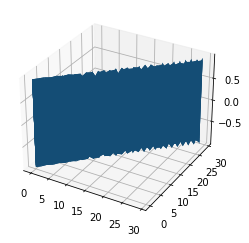

In [18]:
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
z = torch.sin(torch.sqrt(gx * gx + gy * gy))
ax.plot_surface(gx.numpy(),gx.numpy(),z.numpy())

In [19]:
from sklearn.cluster import KMeans
x = np.arange(640)
y = np.arange(640)
g = np.asarray([x,y])
g = g.transpose()

In [20]:
g.shape

(640, 2)

In [24]:
k = KMeans(n_clusters=9)
k.fit(g)
p = k.predict(g)
anch = []
for i in range(9):
    anch.append(np.mean(g[i==p],axis=0))
anch = np.array(anch)
anch_c = anch.copy()
anch[...,0] = anch_c[...,0] / 640*640
anch[...,1] = anch_c[...,1] / 640*640

In [25]:
print(anch)

[[467.5 467.5]
 [107.5 107.5]
 [322.  322. ]
 [605.5 605.5]
 [395.  395. ]
 [249.5 249.5]
 [ 35.5  35.5]
 [178.5 178.5]
 [537.5 537.5]]
